## Escaping Elo Hell: The Analysis of High Elo Games to Get Out of Silver

##### In this Jupyter Notebook, we will try to explore a subset of factors in their effect of increasing the chance of winning your game. To achieve this, we will perform t-tests to compare the distributions between winning and losing factors to identify the most significant factors. Logestic regression will then be used to compare their effectiveness in predicting winning and losing games. 

#### Importing Libraries

In [1]:
import seaborn as sns; sns.set_style("dark") # Dark theme for seaborn plots
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#### Functions

In [2]:
def load_datasets(filenames):
    """
    Load and combine data from multiple datasets
    """
    dataset = pd.read_csv(filenames[0])
    for file in filenames[1:]:
        dataset.append(pd.read_csv(file))
    return dataset

def get_team_stats(data, team):
    """
    Dr Steven Bamford's function to extract relevant team stats
    """
    team_cols = data.columns.str.startswith(team)
    team_stats = data.loc[:, team_cols]
    team_stats = team_stats.rename(columns=lambda x: x.replace(team, ''))
    team_stats['Team'] = team
    return team_stats
    
def get_mean_stats(data, factor):
    """
    Returns mean of data
    """
    return np.mean(data[factor])

def get_value_index(dataframe, value_match):
    """
    Returns index of a given value from a dataframe
    """
    data = dataframe.values
    index = None
    for index, val in enumerate(data):
        if val == value_match:
            return index
    raise ValueError('Value not found.')

def get_ordered_dict(df):
    """
    Returns an ordered dataframe - ideal for transposed single row dataframes with a singular index
    """
    ordered_vals = sorted(df[0])
    ordered_dict = {}
    for i in ordered_vals:
        columnName = df.iloc[get_value_index(df, i)].name
        ordered_dict[columnName] = i
    return ordered_dict

def z_score_normalisation(df):
    """
    Performs Z-score normalisation on dataframe
    """
    for col in df.columns:
        if len(df[col].unique()) > 2: # normalise non-binary features
            mean = df[col].mean() # mean of column
            std = df[col].std() # std of column
            df[col] = np.divide(df[col] - mean, std)
    return df

#### Loading and Dataset Preparation

In [3]:
# List of datasets being used
datasets = ['Challenger_Ranked_Games.csv', 'GrandMaster_Ranked_Games.csv', 'Master_Ranked_Games.csv']
raw_data = load_datasets(datasets)
data = raw_data.drop(columns=
                     ['gameId', 
                      'gameDuraton'], axis=1) # identifier and gameDuration columns not needed for analysis

# Splitting dataset into subsets
"""
Again, Dr Steven Bamford's code for splitting dataset into subsets of red, blue, winner, loser and stats dataframes
"""
red_stats = get_team_stats(data, 'red')
blue_stats = get_team_stats(data, 'blue')
winner_stats = pd.concat([red_stats[red_stats['Wins'] == 1],
                          blue_stats[blue_stats['Wins'] == 1]]).drop(columns=['Wins'], axis=1) # Wins column homogeneous
loser_stats = pd.concat([red_stats[red_stats['Wins'] == 0],
                         blue_stats[blue_stats['Wins'] == 0]]).drop(columns=['Wins'], axis=1) # Wins column homogeneous
all_stats = winner_stats.join(loser_stats,
                           lsuffix='_winner',
                           rsuffix='_loser')
all_stats = all_stats.sort_index()

#### Dataset Inspection

##### Visualising Some of the Different Factors Between Winning and Losing Teams

We can utilise histograms to visualise the distributions of some factors in winning and losing teams to compare their effectiveness.

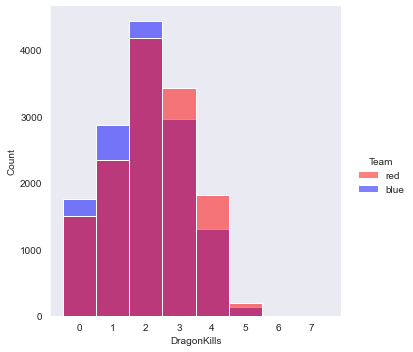

In [4]:
sns.displot(winner_stats, x="DragonKills", hue="Team", palette=["red", "blue"], alpha=0.5, discrete=True)

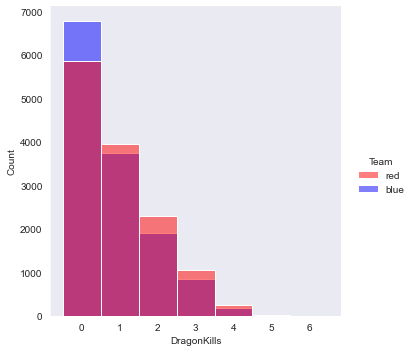

In [5]:
sns.displot(loser_stats, x="DragonKills", hue="Team", palette=["red", "blue"], alpha=0.5, discrete=True)

Kernel Density Estimation (KDE) provides non-parametric estimation for the probability density function of random variables. Here, we use KDE to visualise the distribution instead due to the large range of values contained; we can estimate the distribution otherwise shown by a histogram.

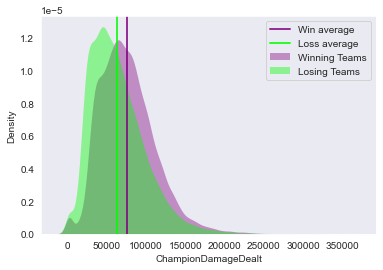

In [6]:
# KDE plots
sns.kdeplot(winner_stats['ChampionDamageDealt'], x="ChampionDamageDealt", label='Winning Teams', fill=True, alpha=0.4, linewidth=0, color='purple')
sns.kdeplot(loser_stats['ChampionDamageDealt'], x="ChampionDamageDealt", label='Losing Teams', fill=True, alpha=0.4, linewidth=0, color='lime')

# Get mean value of factor
win_mean = get_mean_stats(winner_stats, 'ChampionDamageDealt')
loss_mean = get_mean_stats(loser_stats, 'ChampionDamageDealt')

# Plot means
plt.axvline(linewidth=2, color='purple', x=win_mean, alpha=0.8, label="Win average")
plt.axvline(linewidth=2, color='lime', x=loss_mean, alpha=0.8, label="Loss average")

plt.legend()

#### T-test and P-value

In [7]:
statistic, pvalue = stats.ttest_ind(winner_stats['DragonKills'], loser_stats['DragonKills']) # SciPy function for T-test

print("T-test Score:", statistic)
print("P-Value:", pvalue)

T-test Score: 122.08295869452438
P-Value: 0.0


T-test is a method of distribution comparison which numerically quantifies their difference. Here, we use t-test to compare the two indepdendent samples of our 'DragonKills' variable. It is clear that there are clear statistical significance between the samples visually and the value returned by the t-test further proves this. The results returned by the t-test above states the winning and losing distributions of dragons killed are 122 times as different from each other. 

The t-test value is acompanied by a p-value which signifies the probability the statistic returned by the t-test occured by random chance. For p-values under 0.05 or 5%, we can safely assume that our result did not occur by random chance.

Intuitively, a significant difference should be expected as dragon kills serve to provide extra advantages to the slaying team (e.g. gold, increased stats). All the factors recorded by our data should indicate some difference between in the samples of factors between the winning and losing sides.

Since we can expect there to be clear difference in all our samples, we would need to iterate through every factor to identify the most significant distributions. The most significant distributions could indicate the most important factor in winning a league match.

#### Performing T-test on All Factors

In [8]:
winner_stats.describe() # Inspect data

,FirstBlood,FirstTower,FirstBaron,FirstDragon,FirstInhibitor,DragonKills,BaronKills,TowerKills,InhibitorKills,WardPlaced,...,Assist,ChampionDamageDealt,TotalGold,TotalMinionKills,TotalLevel,AvgLevel,JungleMinionKills,KillingSpree,TotalHeal,ObjectDamageDealt
count,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,...,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000,26904.000000
mean,0.602438,0.717663,0.421238,0.587682,0.659865,2.071291,0.523602,6.684842,1.090656,60.116005,...,50.009887,75973.973350,52443.301033,537.768139,68.227290,13.645458,144.215544,7.001524,28610.618421,52200.461047
std,0.489403,0.450145,0.493767,0.492261,0.473763,1.219190,0.619325,2.679547,0.948080,31.346470,...,26.765204,35433.892945,14415.818779,170.225099,13.222776,2.644555,65.481477,3.155223,15803.251066,24613.479054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4038.000000,5.000000,6.000000,1.200000,0.000000,0.000000,235.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000,40.000000,...,32.000000,50495.000000,42793.000000,432.000000,60.000000,12.000000,107.000000,5.000000,17129.750000,34292.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,7.000000,1.000000,59.000000,...,46.000000,71975.000000,52739.500000,549.000000,69.000000,13.800000,150.000000,7.000000,25771.500000,53584.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,9.000000,2.000000,80.000000,...,61.000000,96345.000000,61861.250000,649.000000,77.000000,15.400000,188.000000,9.000000,36877.250000,69502.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,4.000000,11.000000,9.000000,230.000000,...,238.000000,359184.000000,124123.000000,1443.000000,132.000000,26.400000,432.000000,29.000000,188603.000000,167692.000000


In this section we will build a dataset containing the t-test scores of the distribution comparisons between winning and losing teams of in-game factors.

In [9]:
# Pandas dataframe to store t-test scores
df_ttest = pd.DataFrame(columns=winner_stats.columns[:-1]) # Exclude Team column
statistics = []

# Calculate t-test score and append to list
for column in winner_stats:
    if column != 'Team': # Ignore team column
        statistic, pvalue = stats.ttest_ind(winner_stats[column], loser_stats[column])        
        if pvalue < 0.05: # Statistic is not random chance
            statistics.append(abs(statistic)) # Interested in magnitude only

# Append t-test scores to pandas dataframe
df_ttest.loc[df_ttest.shape[0], :] = statistics

df_ttest = df_ttest.transpose()
df_ttest

,0
FirstBlood,49.0503
FirstTower,115.92
FirstBaron,95.417
FirstDragon,64.1591
FirstInhibitor,188.215
DragonKills,122.083
BaronKills,91.8315
TowerKills,233.009
InhibitorKills,153.072
WardPlaced,10.174


Some of the t-test scores above are expected to be large. This however, is of little use to us as we are identifying the less obvious factors in winning a league game. Also, there are duplicate t-test scores due to the factor measuring the same quality i.e. both factors are a measure of experience - one of which must be dropped.

In [10]:
df_ttest = df_ttest.transpose().drop(columns=[
    'TowerKills',
    'InhibitorKills',
    'TotalLevel', # Duplicate, describes experience metric
    'ObjectDamageDealt'
])

df_ttest

,FirstBlood,FirstTower,FirstBaron,FirstDragon,FirstInhibitor,DragonKills,BaronKills,WardPlaced,Wardkills,Kills,Death,Assist,ChampionDamageDealt,TotalGold,TotalMinionKills,AvgLevel,JungleMinionKills,KillingSpree,TotalHeal
0,49.0503,115.92,95.417,64.1591,188.215,122.083,91.8315,10.174,18.3763,116.119,115.471,90.8273,41.6991,65.9795,18.8477,52.4921,52.1844,106.121,52.0405


The columns dropped above are either a duplicate measuring the same factor, or are objectives required to win the game and thus their distributions, therfore their t-scores are expect to be significant. 

In [11]:
ordered_dict = get_ordered_dict(df_ttest.transpose())
df_ttests = pd.DataFrame(columns=ordered_dict.keys())
df_ttests.loc[df_ttests.shape[0], :] = list(ordered_dict.values())

df_ttests = df_ttests.transpose()

df_ttests

,0
WardPlaced,10.174
Wardkills,18.3763
TotalMinionKills,18.8477
ChampionDamageDealt,41.6991
FirstBlood,49.0503
TotalHeal,52.0405
JungleMinionKills,52.1844
AvgLevel,52.4921
FirstDragon,64.1591
TotalGold,65.9795


#### Above Average Factors

In [12]:
mean_ttest = get_mean_stats(df_ttests, 0)


above_avg_factors = df_ttests[df_ttests[0] > mean_ttest]
below_avg_factors = df_ttests[df_ttests[0] <= mean_ttest]

# Factors of greater importance to winning a leage match
above_avg_factors

,0
Assist,90.8273
BaronKills,91.8315
FirstBaron,95.417
KillingSpree,106.121
Death,115.471
FirstTower,115.92
Kills,116.119
DragonKills,122.083
FirstInhibitor,188.215


#### Brief Analysis of Factors from T-tests

Teams first to destory the opposing team's inhibitor gave the largest difference in their distributions when comparing losing and winning teams. Becoming the team to first achieve this objective could be the strongest indicator for a winning team. The factors that follow i.e. DragonKills and Kills distributions are expected to have higher t-test scores as they also indicate a stronger side. FirstTower is shown to be a suprisingly strong indicator when compared to FirstBaron and FirstDragon, which although is less important than DragonKills.

#### Logestic Regression

To test the predictive power of our 'important' factors, we will fit a logestic regression model and compare its performance to another logestic regression model fitted with the less 'important' factors. Ideally, our results should reinforce the factors above as better predictors of team performance compared to the other factors.

##### Dataset Preparation for Logestic Regression

In [13]:
# Column names
more_important_factors = above_avg_factors.transpose().columns
less_important_factors = below_avg_factors.transpose().columns

# Combine red team and blue team dataframes
combined_stats = red_stats.append(blue_stats).drop(columns=['Team']) # Interested in winning factors, not team

# Get relevant column data
greater_factors = combined_stats[more_important_factors]
lesser_factors = combined_stats[less_important_factors]

lesser_factors # Note that there are more factors within this dataset

,WardPlaced,Wardkills,TotalMinionKills,ChampionDamageDealt,FirstBlood,TotalHeal,JungleMinionKills,AvgLevel,FirstDragon,TotalGold
0,50,17,533,73016,0,38711,138,12.8,1,49832
1,46,18,571,44218,1,24829,134,11.8,0,37136
2,40,9,400,30797,1,12589,89,10.0,1,35364
3,96,56,832,125866,1,65312,205,16.8,0,70528
4,100,43,794,131536,0,86431,227,17.0,0,74596
...,...,...,...,...,...,...,...,...,...,...
26899,72,20,438,99418,1,20122,106,12.0,0,41437
26900,37,2,346,61816,1,32837,28,13.0,1,61221
26901,72,29,568,51604,1,18131,132,12.6,1,45013
26902,91,25,640,93059,1,75427,168,15.2,1,58160


##### Preprocessing - Normalisation

In [14]:
lesser_factors = z_score_normalisation(lesser_factors)
lesser_factors

C:\Users\Sijan\Anaconda3\envs\stats_lol\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,WardPlaced,Wardkills,TotalMinionKills,ChampionDamageDealt,FirstBlood,TotalHeal,JungleMinionKills,AvgLevel,FirstDragon,TotalGold
0,-0.277459,-0.332742,0.054125,0.094339,0,0.882375,0.123329,-0.079429,1,0.105676
1,-0.404497,-0.267768,0.268195,-0.709747,1,-0.029498,0.061449,-0.434436,0,-0.710697
2,-0.595053,-0.852539,-0.695120,-1.084482,1,-0.833512,-0.634696,-1.073448,1,-0.824639
3,1.183471,2.201266,1.738519,1.569993,1,2.629726,1.159812,1.340598,0,1.436462
4,1.310508,1.356597,1.524449,1.728309,0,4.016978,1.500150,1.411599,0,1.698041
...,...,...,...,...,...,...,...,...,...,...
26899,0.421246,-0.137819,-0.481050,0.831524,1,-0.338689,-0.371708,-0.363435,0,-0.434136
26900,-0.690331,-1.307361,-0.999325,-0.218383,1,0.496527,-1.578360,-0.008428,1,0.838007
26901,0.421246,0.446953,0.251295,-0.503518,1,-0.469473,0.030509,-0.150431,1,-0.204193
26902,1.024674,0.187054,0.656901,0.653971,1,3.294154,0.587426,0.772587,1,0.641180


In [15]:
greater_factors = z_score_normalisation(greater_factors)
greater_factors

C:\Users\Sijan\Anaconda3\envs\stats_lol\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Assist,BaronKills,FirstBaron,KillingSpree,Death,FirstTower,Kills,DragonKills,FirstInhibitor
0,1.012989,-0.586318,0,0.701790,-0.709150,1,0.527709,1.193292,1
1,-1.149482,-0.586318,0,-0.729236,-0.401646,1,-1.242943,-1.156923,0
2,-0.716988,-0.586318,0,-0.156826,-1.477913,1,-0.319125,0.409887,1
3,1.157154,1.236458,0,0.987995,0.136488,1,0.912633,1.193292,0
4,1.553607,1.236458,0,0.415585,0.213364,0,1.220572,1.193292,0
...,...,...,...,...,...,...,...,...,...
26899,0.364248,-0.586318,0,0.701790,0.290240,0,-0.011185,-0.373518,0
26900,-0.140329,-0.586318,0,-0.156826,1.366507,1,0.373739,1.193292,0
26901,-0.753029,-0.586318,0,-0.443031,-0.324769,1,-0.781034,-0.373518,0
26902,0.940907,-0.586318,0,0.415585,-0.401646,0,0.604693,1.193292,0


##### Dataset Preparation - Train/Test Split

In [42]:
X_greater = greater_factors
X_lesser = lesser_factors
y = combined_stats.Wins # Predicting win or loss

# Train and test splits
X_train_greater, X_test_greater, X_train_lesser, X_test_lesser, y_train, y_test = train_test_split(
    X_greater, X_lesser, y, test_size=0.3)

##### Model - Training

In [43]:
model_greater = LogisticRegression().fit(X_train_greater, y_train)
model_lesser = LogisticRegression().fit(X_train_lesser, y_train)

##### Model - Evaluation

In [46]:
print("Factors: {greater_columnNames} \n\n Classification Accuracy: {greater_acc:.3f}".format(
            greater_columnNames=list(greater_factors.columns),
            greater_acc=acc_greater))
print()
print("Factors: {lesser_columnNames} \n\n Classification Accuracy: {lesser_acc:.3f}".format(
            lesser_columnNames=list(lesser_factors.columns),
            lesser_acc=acc_lesser))

Factors: ['Assist', 'BaronKills', 'FirstBaron', 'KillingSpree', 'Death', 'FirstTower', 'Kills', 'DragonKills', 'FirstInhibitor'] 

 Classification Accuracy: 0.952

Factors: ['WardPlaced', 'Wardkills', 'TotalMinionKills', 'ChampionDamageDealt', 'FirstBlood', 'TotalHeal', 'JungleMinionKills', 'AvgLevel', 'FirstDragon', 'TotalGold'] 

 Classification Accuracy: 0.766


The model accuracies presented above further justify the 'greater factors' as strong indicators of game win or loss when evaluating its 95.2% accuracy against 76.6% accuracy of the 'lesser factors'. Despite containing one less factor, it clearly outperforms 'lesser factors' when used to predict a win or loss. This suggests that these attributes have greater impact to winning or losing a high elo league game.

#### Conclusion

The purpose of this notebook was to explore a dataset containing approximately 30,000 high-elo league of legend games to identify strong factors that increase chances of winning league games. We performed a brief inspection of some factors captured by our data; using visualisation methods such as histograms and kernel density estimations to visualise their distributions. We then utilised t-tests to rank these distributions into two subsets, stronger factors and weaker factors. To measure the effectiveness of these subsets, logestic regression models were trained on these subsets to predict wins and loses of league games.  

To conclude, teams first to destory an opponents inhibitor is the strongest indication of the winning team. Objectives such as dragons should also be prioritised as they are the second best indicator of a winning side although they hold less of an importance to be first when compared to the baron objective. The most informative insight however, would be the significance of achieving first tower. This game statistic is shown to be the fourth best and also the earliest indication of a winning side.